# Driver Identification using Deep learning

In [2]:
import pandas as pd  # pip install pandas
%matplotlib inline
import matplotlib.pyplot as plt # pip install matplotlib
#import seaborn as sns; sns.set()  # for plot styling
import numpy as np

data=pd.read_csv('full_data_test.csv')

columns2=["Long_Term_Fuel_Trim_Bank1","Intake_air_pressure","Accelerator_Pedal_value","Fuel_consumption","Torque_of_friction","Maximum_indicated_engine_torque","Engine_torque","Calculated_LOAD_value",
"Activation_of_Air_compressor","Engine_coolant_temperature","Transmission_oil_temperature","Wheel_velocity_front_left-hand","Wheel_velocity_front_right-hand","Wheel_velocity_rear_left-hand",
"Torque_converter_speed"]

#The anomalie detector using the One-Class Support Vector Machine

from sklearn import svm
ano_det = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1) # nu is upper bound, gamma  , kernal coeffient of rbf (), 1 / (n_features * X.var()) as value of gamma 
ano_det.fit(data[columns2])



OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [3]:
# Preprocessing of the data


classes=['A','B','C','D','E','F','G','H','I','J']


drivers =[]
for c in classes:
    drivers.append(data[data['Class']==c])
dataa=[]
for c in range(len(drivers)):
    nt=0
    nv=0
    drivers[c]=drivers[c].reset_index(drop=True)
    idxs=drivers[c][drivers[c]['Time(s)']==1].index.values
    for i in range(len(idxs)):
        if i <(len(idxs)-1):
            nt=nt+1
            dataa.append(drivers[c][idxs[i]:idxs[i+1]])
        if i==(len(idxs)-1):
            nv=nv+1
            dataa.append(drivers[c][idxs[i]:])
    print("Driver : "+str(c)+" number of trips :"+str(len(idxs))+ "  For Train : "+str(nt)+"  For valid :"+str(nv))


drivers=[]
ss=0
for i in range(len(dataa)):
    #print(n)
    n=int(len(dataa[i])/60)
    #print(" Drive "+str(i)+" contains "+str(n)+" subdriversets")
    dd=0
    for j in range(n):
        #print(j)
        temp=dataa[i][dd:dd+60]
        temp=temp.reset_index(drop=True)
        drivers.append(temp)
        ss=ss+1
        dd=dd+60
print("total is "+str(ss))

  

samples = list()
labels=list()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[columns2].values)
for c in drivers:
    labels.append(c['Class'][0])
    del c['Class']
    del c['Time(s)']
    samples.append(scaler.transform(c[columns2].values))
data = np.array(samples)
print(data.shape)



Driver : 0 number of trips :4  For Train : 3  For valid :1
Driver : 1 number of trips :6  For Train : 5  For valid :1
Driver : 2 number of trips :4  For Train : 3  For valid :1
Driver : 3 number of trips :6  For Train : 5  For valid :1
Driver : 4 number of trips :4  For Train : 3  For valid :1
Driver : 5 number of trips :4  For Train : 3  For valid :1
Driver : 6 number of trips :4  For Train : 3  For valid :1
Driver : 7 number of trips :4  For Train : 3  For valid :1
Driver : 8 number of trips :4  For Train : 3  For valid :1
Driver : 9 number of trips :4  For Train : 3  For valid :1
total is 1551
(1551, 60, 15)


In [4]:
data[0].shape

(60, 15)

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels=le.transform(labels) 


from keras import optimizers


# Doing the cross validation and training the model

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=31)
X_test, X_predict, y_test, y_predict = train_test_split(X_train, y_train, test_size=0.1, random_state=31)

Using TensorFlow backend.


In [6]:
X_train.shape

(1085, 60, 15)

In [7]:
X_test.shape

(976, 60, 15)

In [8]:
X_predict.shape

(109, 60, 15)

In [9]:
data.shape[1]

60

In [10]:
data.shape[2]

15

In [15]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *

from keras.models import Model
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers


ip = Input(shape=(data.shape[1], data.shape[2]))
x = Permute((2, 1))(ip)
x=LSTM(10)(x)
x = Dropout(0.8)(x)
y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = GlobalAveragePooling1D()(y)
x = concatenate([x, y])
out = Dense(10, activation='sigmoid')(y)
model = Model(ip, out)


In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 15)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 128)           15488     
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 128)           512       
_________________________________________________________________
activation_4 (Activation)    (None, 60, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 256)           164096    
_________________________________________________________________
batch_normalization_5 (Batch (None, 60, 256)           1024      
_________________________________________________________________
activation_5 (Activation)    (None, 60, 256)           0   

# Train the Model

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=128, verbose=2)

Train on 1085 samples, validate on 976 samples
Epoch 1/30
 - 1s - loss: 1.9628 - accuracy: 0.3585 - val_loss: 2.6062 - val_accuracy: 0.2766
Epoch 2/30
 - 1s - loss: 1.6322 - accuracy: 0.4876 - val_loss: 2.9230 - val_accuracy: 0.3125
Epoch 3/30
 - 1s - loss: 1.4504 - accuracy: 0.5650 - val_loss: 2.9585 - val_accuracy: 0.3227
Epoch 4/30
 - 1s - loss: 1.2993 - accuracy: 0.5650 - val_loss: 2.5636 - val_accuracy: 0.3576
Epoch 5/30
 - 1s - loss: 1.1700 - accuracy: 0.6212 - val_loss: 2.3638 - val_accuracy: 0.3627
Epoch 6/30
 - 1s - loss: 1.0365 - accuracy: 0.6461 - val_loss: 2.0234 - val_accuracy: 0.3791
Epoch 7/30
 - 1s - loss: 0.9201 - accuracy: 0.7226 - val_loss: 1.7272 - val_accuracy: 0.4068
Epoch 8/30
 - 1s - loss: 0.8249 - accuracy: 0.7493 - val_loss: 1.5582 - val_accuracy: 0.4580
Epoch 9/30
 - 1s - loss: 0.7279 - accuracy: 0.7871 - val_loss: 1.4280 - val_accuracy: 0.4959
Epoch 10/30
 - 1s - loss: 0.6374 - accuracy: 0.8221 - val_loss: 1.2245 - val_accuracy: 0.5686
Epoch 11/30
 - 1s - lo

In [18]:
model.save('Driver_Profiling.h5') 

In [19]:
model.evaluate(X_test, y_test)

976/976 [==============================] - 0s 226us/step


[0.19421542081676546, 0.9661885499954224]

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


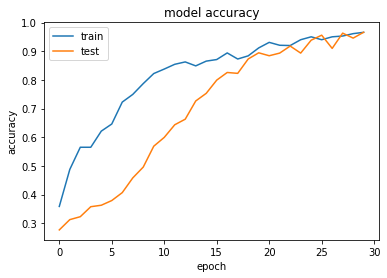

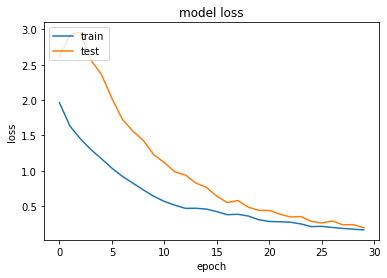

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
import pandas as pd

In [22]:
 #Adding some anomalies to the data to test the performance of the model
import random
rates=[0,0.01,0.1,0.3,0.5]
rows=[1,10]
sensors=[7]

results=pd.DataFrame(columns=["Rate","Rows","Sensors","Accuracy"])
for rate in rates:
      for row in rows:
        for sensor in sensors:
            X_test2=X_test.copy()
            total=X_test.shape[0]*X_test.shape[1]*X_test.shape[2]
            total=int(311*rate)
            n=sensor
            nrows=row
            for i in range(total):
                if(i%10000==0):
                    print(i)
                fst=random.randint(0,X_test.shape[0]-1)
                snd=random.randint(0,X_test.shape[1]-nrows)
                trh2=random.sample(range(0, X_test.shape[2]), n)
                for j in range(n):
                    for jj in range(nrows):
                        X_test2[fst][snd+jj][trh2[j]]=X_test2[fst][snd+jj][trh2[j]]+3000
            acc=round(model.evaluate(X_test2, y_test)[1]*100,2)
            results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)
    #model.evaluate(X_test2, y_test)


print(results)

976/976 [==============================] - 0s 205us/step
0
976/976 [==============================] - 0s 208us/step
0
976/976 [==============================] - 0s 219us/step
0
976/976 [==============================] - 0s 222us/step
0
976/976 [==============================] - 0s 207us/step
0
976/976 [==============================] - 0s 210us/step
0
976/976 [==============================] - 0s 237us/step
0
976/976 [==============================] - 0s 238us/step
0
976/976 [==============================] - 0s 231us/step
    Rate Rows Sensors  Accuracy
0     0%    1       7     96.62
1     0%   10       7     96.62
2   1.0%    1       7     96.31
3   1.0%   10       7     96.41
4  10.0%    1       7     93.65
5  10.0%   10       7     93.65
6  30.0%    1       7     88.73
7  30.0%   10       7     88.93
8  50.0%    1       7     82.99
9  50.0%   10       7     82.79


In [28]:
model = keras.models.load_model('Driver_Profiling.h5')

In [45]:
Live_Data= np.expand_dims(X_predict[6],axis=0)

In [46]:
X_predict[1].shape

(60, 15)

In [47]:
pred = model.predict(Live_Data)

In [48]:
np.argmax(pred)

5

In [49]:
y_predict[6]

5

In [44]:
y_predict

array([6, 4, 5, 4, 6, 3, 5, 8, 3, 8, 1, 3, 3, 5, 8, 6, 2, 2, 0, 4, 0, 4,
       9, 3, 5, 1, 8, 6, 4, 3, 5, 4, 5, 8, 7, 8, 7, 3, 1, 0, 0, 1, 7, 0,
       3, 1, 0, 9, 1, 9, 3, 3, 3, 6, 5, 6, 8, 3, 6, 4, 7, 2, 8, 6, 5, 7,
       7, 1, 1, 1, 4, 4, 2, 2, 2, 5, 6, 7, 8, 3, 5, 9, 1, 1, 5, 7, 2, 2,
       7, 0, 5, 7, 8, 8, 3, 5, 4, 1, 1, 4, 3, 1, 7, 2, 4, 4, 5, 7, 5],
      dtype=int64)